In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
import sys
import module_extraction
import clustering
from module_extraction_ortho import Filters, Modules

分析対象の指定

In [7]:
# -- 個別画像 --
#input_img_path = '../ModuleExtraction/hokuto/thermal/DJI_0123_R.JPG'
#thermal_npdat_path = "../ModuleExtraction/hokuto/thermal"

# --オルソ画像 --
#input_img_path = 'images/ortho/izuka.tif' # failed
input_img_path = './images/ortho/chiba.tif'

#input_img_path = 'images/ortho/1391.tif'
#input_img_path = 'images/ortho/1477.tif' # fair
#input_img_path = 'images/ortho/1466.tif'
#input_img_path = 'images/ortho/1480.tif' # failed

#input_img_path = 'images/ortho/1411.tif' #failed
#input_img_path = 'images/ortho/1481.tif' #fair
#input_img_path = 'images/ortho/1441.tif' # failded
#input_img_path = 'images/ortho/1473.tif' #failed

In [8]:
output_dir_path = "../images/"+input_img_path.split("/")[-1][:-4]
print(output_dir_path)

../images/chiba


フィルタの適用

In [9]:
#filters = Filters(thermal_npdat_path)
filters = Filters()

In [10]:
img_org = cv2.imread(input_img_path, 0)

/Users/tnozawa/afterFIT/work/rule_based_anomaly_detection/module_extraction.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


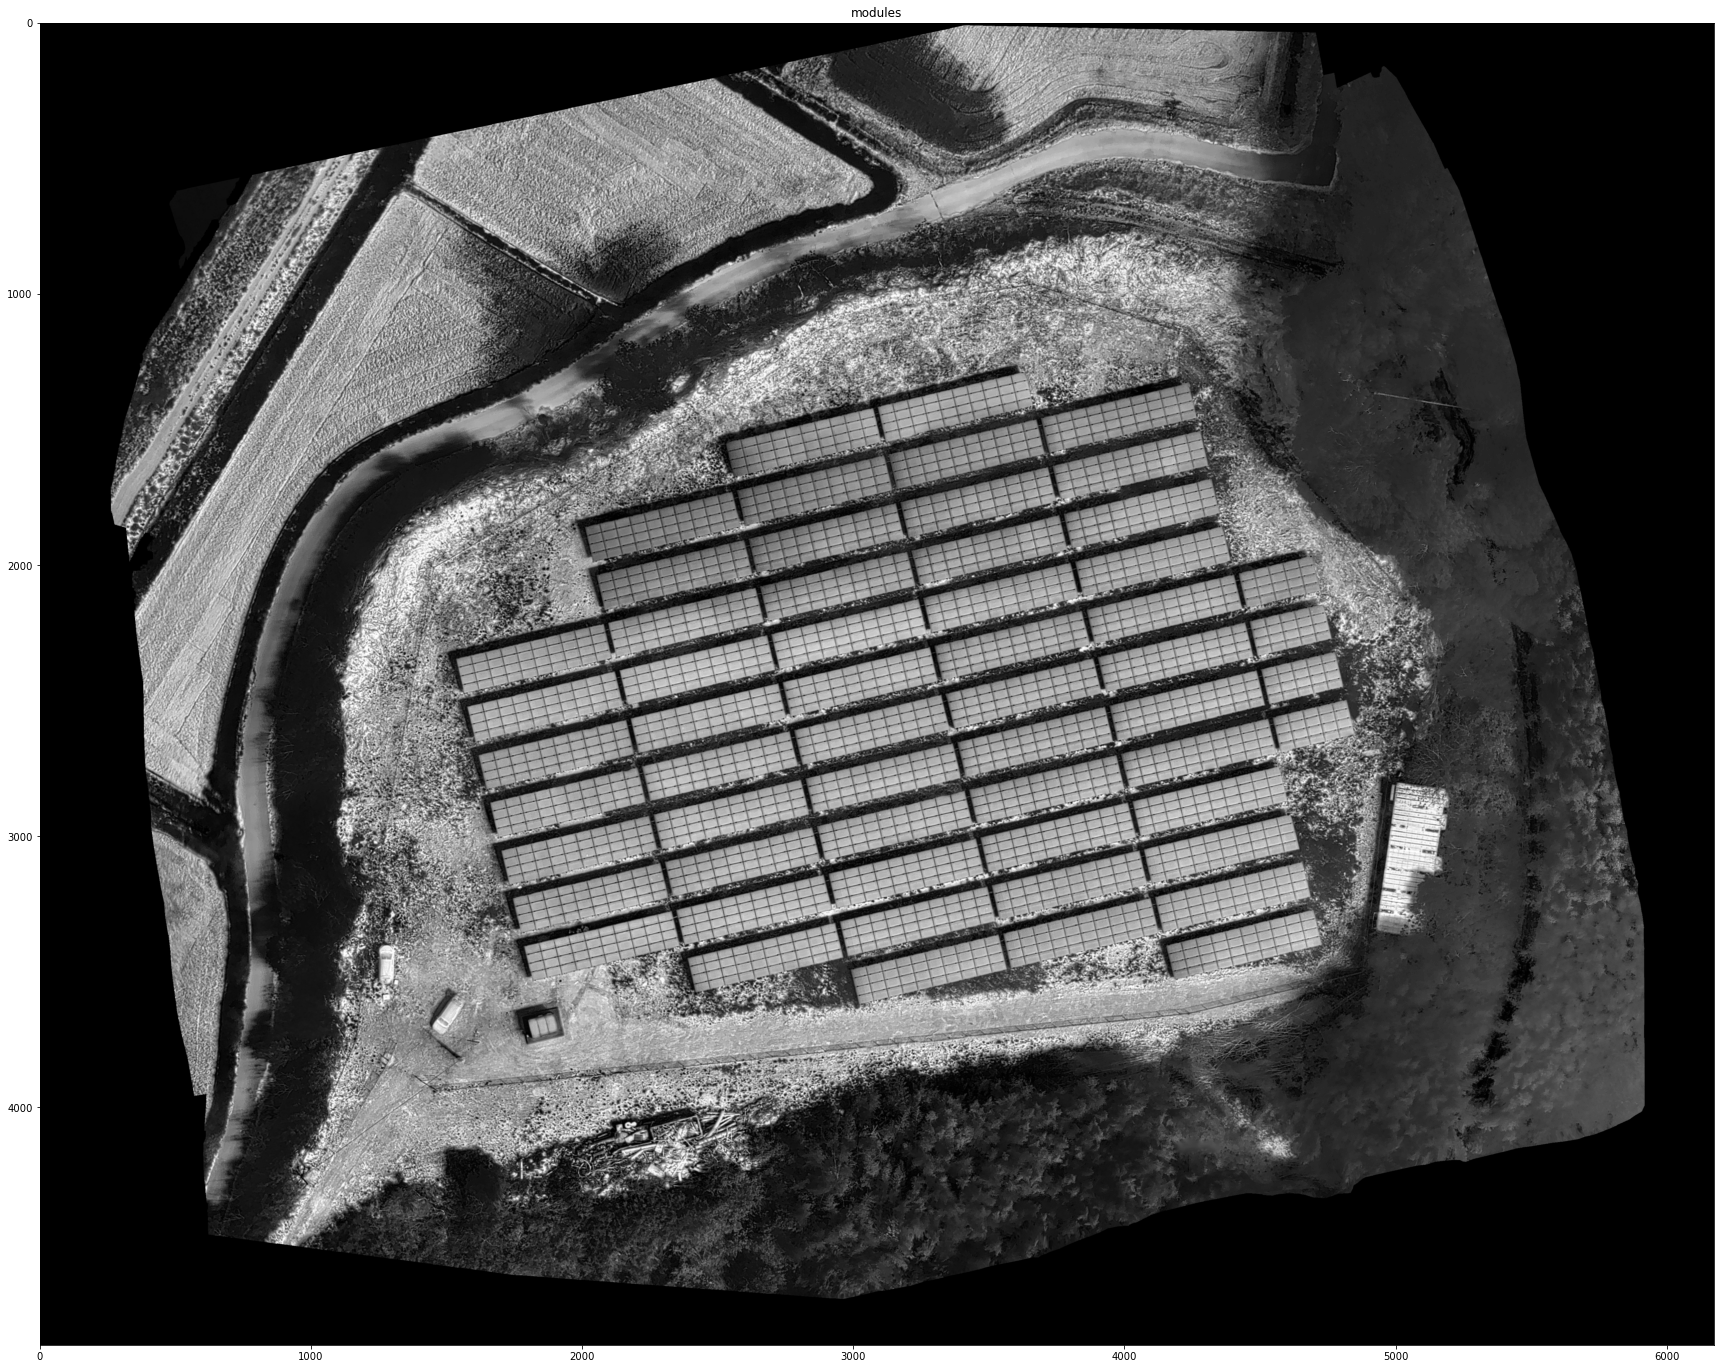

In [11]:
# 元画像
module_extraction.show_img({"modules":img_org},cmap="gray",figsize=(30,30))

In [12]:
# 部分抽出
#img_cut = img_org[6000-1000: 6000+1000, 6000-1000: 6000+1000]
#module_extraction.show_img({"modules":img_cut},cmap="gray",figsize=(30,30))

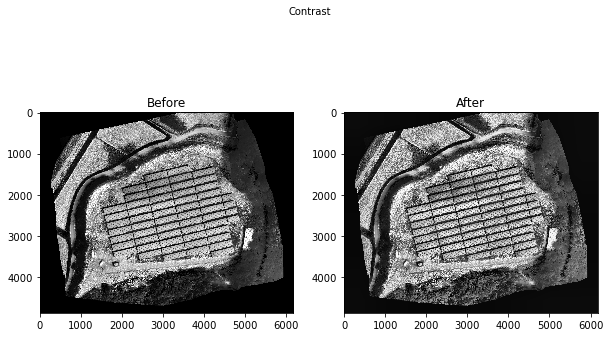

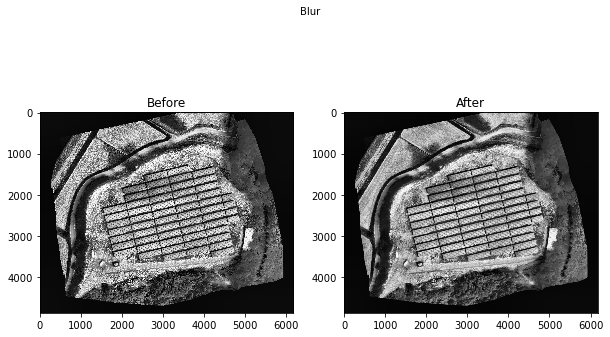

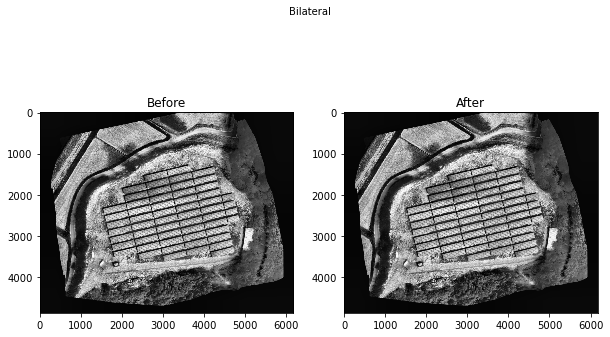

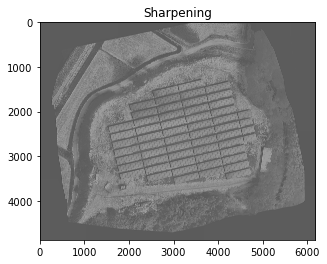

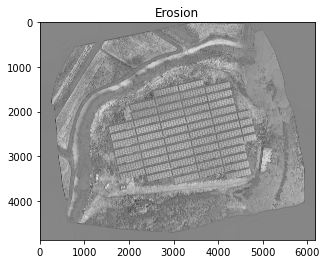

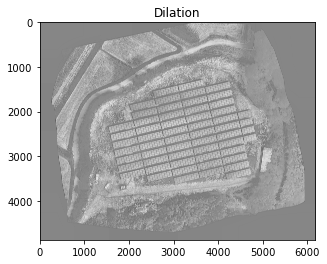

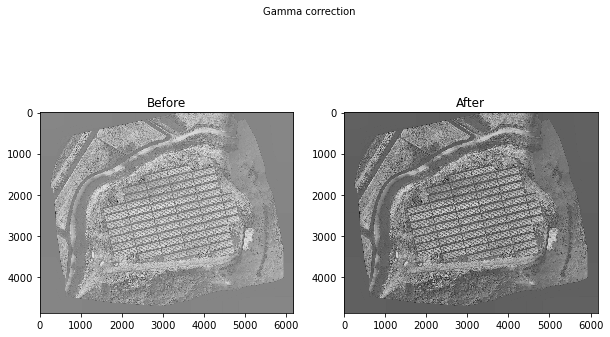

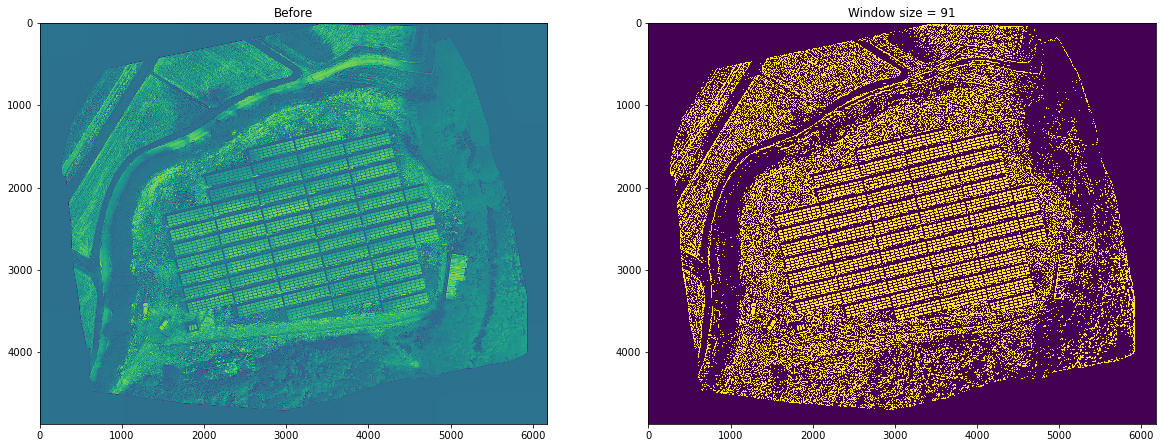

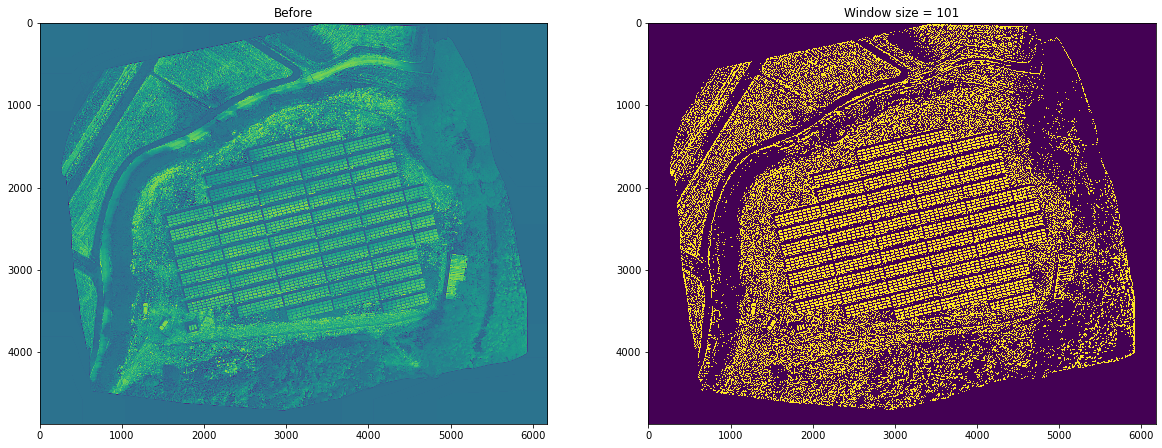

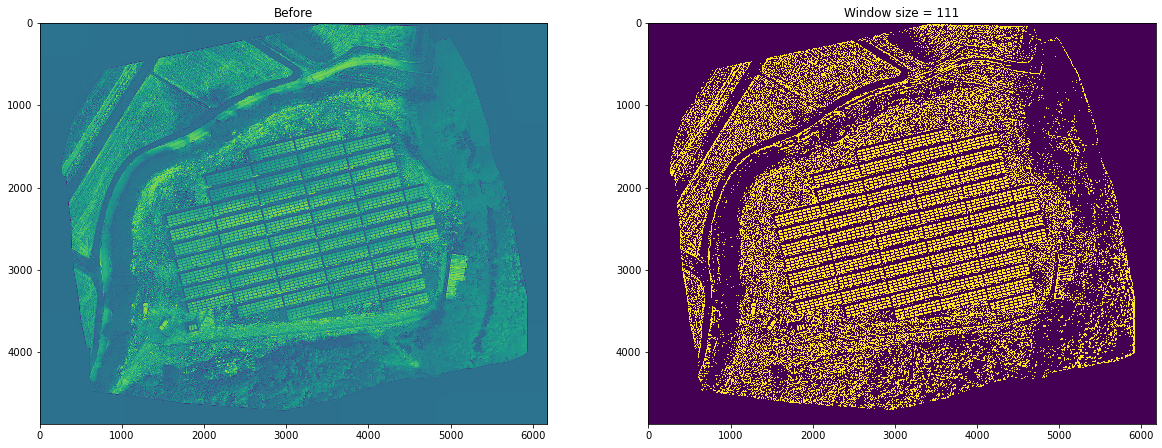

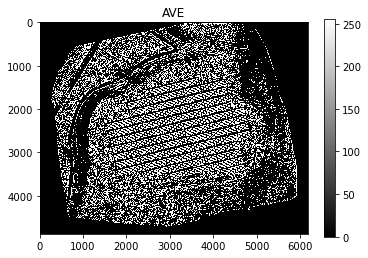

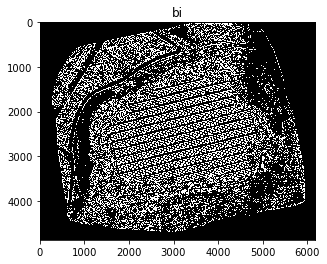

In [ ]:
# 前処理
candidate_module_contours = filters.get_module_contours(img_org)

In [ ]:
# モジュール抽出画像
img_con = cv2.drawContours(np.zeros_like(img_org), candidate_module_contours, -1, 255, -1)
img_mask = cv2.bitwise_and(img_org, img_con)

In [ ]:
module_extraction.show_img({"modules":img_mask},cmap="gray",figsize=(30,30))

モジュールのクラスタリング

In [ ]:
import clustering
modules = Modules(candidate_module_contours)
module_labels = modules.get_dbscan_labels(candidate_module_contours)

In [ ]:
fig, ax = plt.subplots(facecolor="w", figsize=(25,20))
#cmap = plt.get_cmap("tab20")
colors = list(matplotlib.colors.XKCD_COLORS.items())[:max(module_labels)+1]
module_centers = np.array( [c.mean(axis=0) for c in candidate_module_contours] )
for i in range(-1,max(module_labels)):
    data = module_centers[module_labels == i]
    plt.scatter(data[:, 0], data[:, 1], color=colors[i][1], label=str(i))
#plt.scatter(module_centers[:, 0], module_centers[:, 1], color=cmap(module_labels+1), label=)
ax.legend(loc='upper left')
ax.set_xlim([0, img_con.shape[1]])
ax.set_ylim([img_con.shape[0], 0])
plt.show()

出現頻度の高いラベルのみを残す

In [ ]:
from collections import Counter
counter = Counter(module_labels)

In [ ]:
counter.most_common

In [ ]:
array_labels = np.array([i for (i, count) in counter.most_common() if i>0 and count>20])
#array_labels = np.array([i for (i, count) in counter.most_common() if i>0 and count>10])
module_flags = [label in array_labels for label in module_labels]

In [ ]:
fig, ax = plt.subplots(facecolor="w", figsize=(25,20))
for i in array_labels:
        data = module_centers[module_labels == i]
        plt.scatter(data[:, 0], data[:, 1], color=colors[i][1], label=str(i))
ax.legend(loc='upper left')
ax.set_xlim([0, img_con.shape[1]])
ax.set_ylim([img_con.shape[0], 0])
plt.show() 

真のモジュール情報のみを残す

In [ ]:
true_module_contours = np.array(candidate_module_contours)[module_flags]
modules = Modules(true_module_contours) # 真のモジュール情報に更新
true_module_labels = modules.get_dbscan_labels(true_module_contours)

In [ ]:
img_con_index = modules.get_img_contours(img_org, index=True)
module_extraction.show_img({"extracted modules":img_con_index},cmap="gray",figsize=(30,30))

In [ ]:
img_con = modules.get_img_contours(img_org, index=False)
img_mask = cv2.bitwise_and(img_org, img_con)
img_mask_index = modules.add_index(img_mask)
module_extraction.show_img({"extracted modules (overlay)":img_mask_index},cmap="gray",figsize=(30,30))

In [ ]:
module_centers = np.array( [c.mean(axis=0) for c in true_module_contours] )
fig, ax = plt.subplots(facecolor="w", figsize=(25,20))
for i in range(max(true_module_labels)+1):
    data = module_centers[true_module_labels == i]
    plt.scatter(data[:, 0], data[:, 1], color=colors[i][1], label=str(i))
ax.legend(loc='upper left')
ax.set_xlim([0, img_con.shape[1]])
ax.set_ylim([img_con.shape[0], 0])
plt.show() 

In [ ]:
img_write = cv2.cvtColor(img_mask_index, cv2.COLOR_BGR2RGB)
cv2.imwrite(output_dir_path+'/img_mask_index.png',img_write)

モジュールデータの抽出

In [ ]:
modules.extract_modules(img_org, output_dir_path)

In [ ]:
import pickle
with open(output_dir_path+'/module_contours.pkl', 'wb') as pkl:
    pickle.dump(true_module_contours, pkl)
with open(output_dir_path+'/module_labels.pkl', 'wb') as pkl:
    pickle.dump(true_module_labels , pkl)    